In [ ]:
import os, jax, torch, torchvision
from jax import numpy as jnp
from torch.utils.data import Dataset, DataLoader, default_collate
from matplotlib import pyplot as plt

In [ ]:
class Imagenet(Dataset):
    # def __init__(self, data_path="./data/Data/CLS-LOC/train"):
        # g = os.walk(data_path, topdown=True)
        # self.classes = next(g)[1]
        # self.paths = [os.path.join(dirname, f) for (dirname, _, filenames) in g for f in filenames]

    def __len__(self):
        return 100_000#len(self.paths)

    def __getitem__(self, idx):
        s = torch.randint(128, 256, (2,))
        return torch.rand((3,*s)), torch.ones(1000).float()
        fp = self.paths[idx]
        img = torchvision.io.read_image(fp).float()
        if img.shape[1]<128 or img.shape[2]<128 or img.shape[0]!=3:
            del self.paths[idx]
            os.remove(fp)
            return self.__getitem__(idx)
        label = self.classes.index(fp.split("/")[-2].rstrip(".JPEG"))
        label = torch.eye(1000)[label].float()
        return img, label

def jax_collate(batch, n, key, feature_beta, label_beta, sample_overlap):
    imgs, labels = zip(*batch)
    # Find minimum height and width in this batch
    min_height = min(img.shape[1] for img in imgs)
    min_width = min(img.shape[2] for img in imgs)
    # Resize images to the minimum height and width
    imgs = [torchvision.transforms.functional.resize(img, (min_height, min_width)) for img in imgs]
    # Convert and concat
    imgs = jnp.swapaxes(jnp.stack([jnp.asarray(img) for img in imgs]), 1, -1)
    labels = jnp.stack([jnp.asarray(label) for label in labels])
    
    # Create feature skew augmentations 
    # TODO: check that these four distributions are equally different from each other?
    imgs_rot = jnp.rot90(imgs, k=2, axes=(1,2))
    imgs_inv = 1-imgs
    imgs_inv_rot = jnp.rot90(1-imgs, k=2, axes=(1,2))
    all_augs = jnp.stack([imgs, imgs_rot, imgs_inv, imgs_inv_rot], axis=0)
    # Create n heterogeneous skews by randomly summing the four augmentations, while equally representing them globally
    proportions = jax.vmap(jnp.roll, in_axes=(0,0,None))(jnp.tile(jnp.linspace(0,1,n), (4, 1)), jnp.arange(4), None).T
    proportions = proportions[...,None,None,None,None]
    clients_imgs = all_augs*proportions
    clients_imgs = clients_imgs.sum(axis=1)
    # Scale to [0,1] because we lost that guarantee
    clients_imgs = (clients_imgs - clients_imgs.min(axis=0)) / (clients_imgs.max(axis=0) - clients_imgs.min(axis=0))
    # Share samples between the fully heterogeneous clients according to the provided beta
    mix_frac = int(feature_beta*clients_imgs.shape[1])
    mix_idx = jax.random.choice(key, jnp.arange(clients_imgs.shape[1]), (mix_frac,), replace=False)
    mix_idx_inv = jnp.isin(jnp.arange(clients_imgs.shape[1]), mix_idx, invert=True)
    mix_samples = jnp.tile(clients_imgs[:, mix_idx].reshape(-1, *clients_imgs.shape[2:]), (n,1,1,1,1))
    clients_imgs = jnp.concat([mix_samples, clients_imgs[:, mix_idx_inv]], axis=1)
    # Broadcast labels
    labels = jnp.tile(labels, (n,1,1))
    mix_labels = jnp.tile(labels[:,mix_idx], (1,n,1))
    labels = jnp.concat([mix_labels, labels[:,mix_idx_inv]], axis=1)
    return clients_imgs, labels

In [ ]:
%load_ext autoreload
%autoreload 2
from data import create_imagenet
from matplotlib import pyplot as plt
import jax, optax
from jax import numpy as jnp
from fedflax import train
from flax import nnx
from models import ResNet
n=4

ds_train = create_imagenet(n=n, feature_beta=.1)

def ell(model, model_g, x_batch, y_batch):
    ce = optax.softmax_cross_entropy(model(x_batch), y_batch).mean()
    return ce, (0., ce)

@nnx.jit
@nnx.vmap(in_axes=(0,None,0,0,0))
def train_step(model, model_g, opt, x_batch, y_batch):
    (loss, (prox, ce)), grads = nnx.value_and_grad(ell, has_aux=True)(model, model_g, x_batch, y_batch)
    # grads = jax.tree.map(lambda g: g/2**15, grads)
    opt.update(grads)
    return loss, grads

# Optimizer
opt = lambda model: nnx.Optimizer(
    model,
    optax.adamw(learning_rate=1e-3),
    wrt=nnx.Param
)

# Identically initialized models, interpretable as collection by nnx 
keys = nnx.vmap(lambda k: nnx.Rngs(k))(jnp.array([jax.random.key(42)]*n))
models = nnx.vmap(ResNet)(keys)
# Ditto for optimizers
opts = nnx.vmap(opt)(models)
# Init and save
params, struct = jax.tree.flatten(nnx.to_tree(models))
model_g = nnx.from_tree(jax.tree.unflatten(struct, jax.tree.map(lambda x: jnp.mean(x, axis=0), params)))

for x, y in ds_train:
    loss, grads = train_step(models, model_g, opts, x, y)
    print(loss)
    if jnp.isnan(loss).any():
        print("NaN encountered")
        break

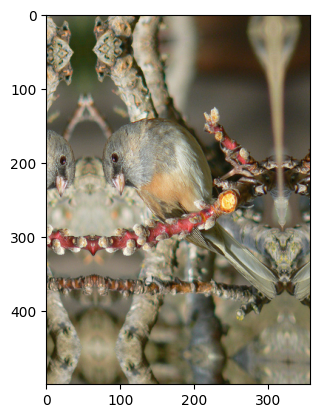

In [115]:
from jax import numpy as jnp
import torchvision
from matplotlib import pyplot as plt
from scipy.ndimage import map_coordinates

def perspective_shift(image, angle, severity):
    # Define image dimensions
    h, w = image.shape[:2]

    # Define source and destination points for homography
    src_pts = jnp.array([[0, 0], [w, 0], [0, h], [w, h]], dtype=jnp.float32)
    dst_pts = jnp.array([[50, 50], [w-50, 20], [70, h-50], [w-30, h-30]], dtype=jnp.float32)

    # Compute homography matrix manually
    def compute_homography(src, dst):
        A = []
        for (x_src, y_src), (x_dst, y_dst) in zip(src, dst):
            A.append([-x_src, -y_src, -1, 0, 0, 0, x_src*x_dst, y_src*x_dst, x_dst])
            A.append([0, 0, 0, -x_src, -y_src, -1, x_src*y_dst, y_src*y_dst, y_dst])
        A = jnp.array(A)
        U, S, Vh = jnp.linalg.svd(A)
        H = Vh[-1].reshape(3, 3)
        return H / H[-1, -1]

    H = compute_homography(dst_pts, src_pts)

    # Generate grid of coordinates in output image
    x_coords, y_coords = jnp.meshgrid(jnp.arange(w), jnp.arange(h))
    homog_coords = jnp.stack([x_coords.ravel(), y_coords.ravel(), jnp.ones_like(x_coords).ravel()])
    mapped_coords = H @ homog_coords
    mapped_coords /= mapped_coords[2]

    # Interpolate each channel
    warped_image = jnp.zeros_like(image)
    for c in range(image.shape[2]):
        warped_image = warped_image.at[..., c].set(map_coordinates(image[..., c], [mapped_coords[1], mapped_coords[0]], order=1, mode='reflect').reshape(h, w))
    return warped_image

image = jnp.swapaxes(jnp.asarray(torchvision.io.read_image("/thesis/data/Data/CLS-LOC/train/n01534433/n01534433_47.JPEG")), 0, -1)
distorted_image = perspective_shift(image, None, None)
plt.imshow(distorted_image)